In [31]:
#!pip install gymnasium

In [32]:
import gymnasium as gym
import numpy as np
import random
from collections import deque, defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [33]:
env = gym.make("Blackjack-v1", natural=False, sab=False)
n_actions = env.action_space.n

***Model sieci DQN***

In [34]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)

pamięć doświadczeń

In [35]:
class ReplayBuffer:
    def __init__(self, size=100000):
        self.buffer = deque(maxlen=size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)


***Funkcja wyboru akcji***

In [36]:
def choose_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    state = torch.tensor(state, dtype=torch.float32)
    q_values = policy_net(state)
    return torch.argmax(q_values).item()

Trening agenta **DQN**

In [37]:
policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
memory = ReplayBuffer()

gamma = 1.0
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995
batch_size = 64
target_update_freq = 2000
num_episodes = 200000


def train_step():
    if len(memory) < batch_size:
        return

    states, actions, rewards, next_states, dones = memory.sample(batch_size)

    # Q(s, a)
    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

    # max_a' Q_target(s', a')
    next_q_values = target_net(next_states).max(1)[0]

    # Bellman target
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, targets.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


rewards_history = []

steps = 0

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        steps += 1

        # epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # wybór akcji
        action = choose_action(state, epsilon)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        total_reward += reward

        memory.push(state, action, reward, next_state, done)
        state = next_state

        loss = train_step()

        # target network update
        if steps % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    rewards_history.append(total_reward)

    if episode % 5000 == 0:
        print(f"Episode {episode}, mean reward: {np.mean(rewards_history[-5000:]):.3f}, epsilon={epsilon:.3f}")

Episode 0, mean reward: 1.000, epsilon=0.999
Episode 5000, mean reward: -0.171, epsilon=0.050
Episode 10000, mean reward: -0.061, epsilon=0.050
Episode 15000, mean reward: -0.091, epsilon=0.050
Episode 20000, mean reward: -0.083, epsilon=0.050
Episode 25000, mean reward: -0.062, epsilon=0.050
Episode 30000, mean reward: -0.103, epsilon=0.050
Episode 35000, mean reward: -0.095, epsilon=0.050
Episode 40000, mean reward: -0.091, epsilon=0.050
Episode 45000, mean reward: -0.099, epsilon=0.050
Episode 50000, mean reward: -0.070, epsilon=0.050
Episode 55000, mean reward: -0.100, epsilon=0.050
Episode 60000, mean reward: -0.067, epsilon=0.050
Episode 65000, mean reward: -0.072, epsilon=0.050
Episode 70000, mean reward: -0.055, epsilon=0.050
Episode 75000, mean reward: -0.076, epsilon=0.050
Episode 80000, mean reward: -0.088, epsilon=0.050
Episode 85000, mean reward: -0.064, epsilon=0.050
Episode 90000, mean reward: -0.052, epsilon=0.050
Episode 95000, mean reward: -0.062, epsilon=0.050
Episod

Ewaluacja

In [38]:
def evaluate(policy_fn, n_games=100000):
    wins = losses = draws = 0

    for _ in range(n_games):
        state, _ = env.reset()
        done = False

        while not done:
            action = policy_fn(state)

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        if reward > 0: wins += 1
        elif reward < 0: losses += 1
        else: draws += 1

    return wins, losses, draws


In [39]:
def dqn_policy(state):
    state_tensor = torch.tensor(state, dtype=torch.float32)
    return torch.argmax(policy_net(state_tensor)).item()

def basic_strategy(state):
    player_sum, dealer_card, usable_ace = state
    return 0 if player_sum >= 17 else 1

wins_dqn, losses_dqn, draws_dqn = evaluate(dqn_policy)
wins_bs,  losses_bs,  draws_bs  = evaluate(basic_strategy)

print("DQN:            Wins:", wins_dqn, "Losses:", losses_dqn, "Draws:", draws_dqn)
print("Basic Strategy: Wins:", wins_bs, "Losses:", losses_bs, "Draws:", draws_bs)
print("Winrates:", wins_dqn / (wins_dqn+losses_dqn+draws_dqn),
      wins_bs / (wins_bs+losses_bs+draws_bs))

DQN:            Wins: 43196 Losses: 47965 Draws: 8839
Basic Strategy: Wins: 40615 Losses: 48805 Draws: 10580
Winrates: 0.43196 0.40615


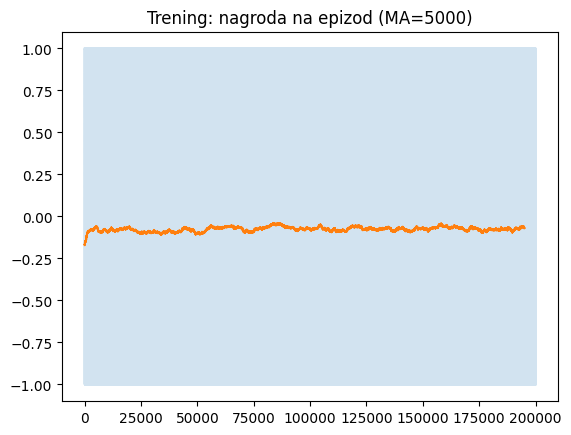

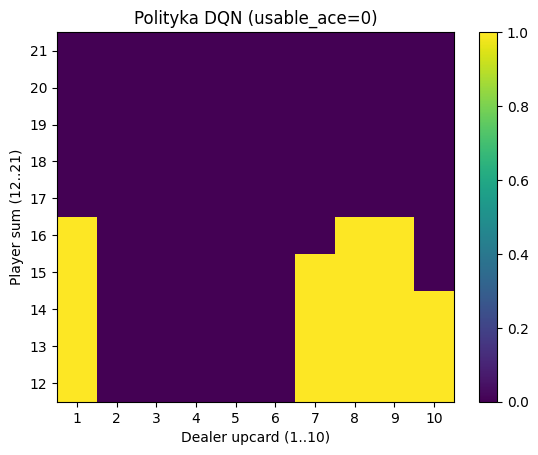

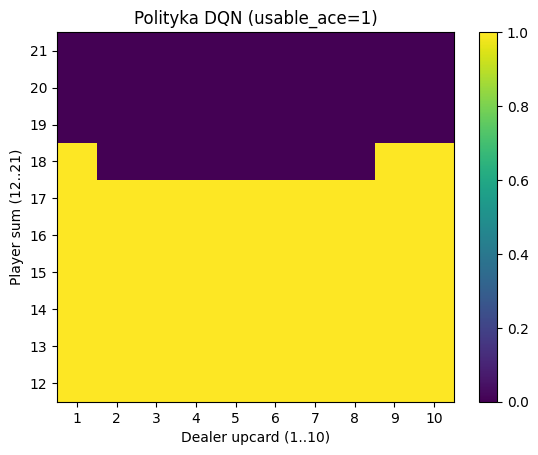

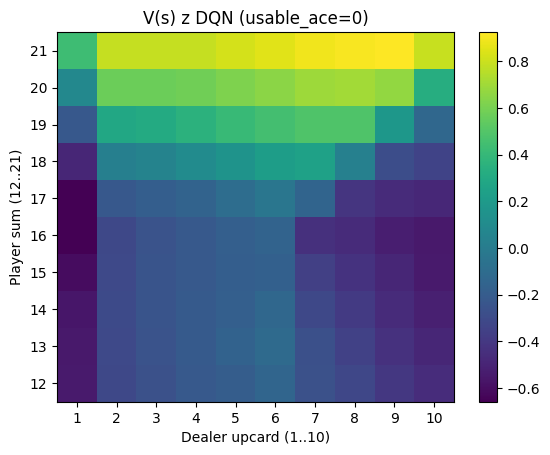

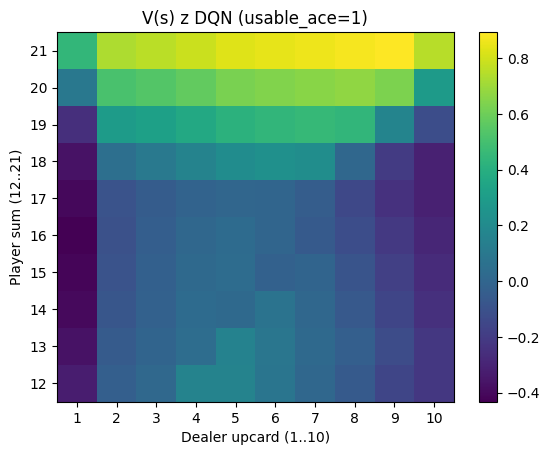

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- wybór historii nagród (u Ciebie jest rewards_history) ---
rewards = None
for k in ["rewards_history", "episode_rewards_history", "episode_rewards", "rewards"]:
    if k in globals():
        rewards = np.asarray(globals()[k], dtype=np.float32)
        break

if rewards is None:
    raise NameError("Nie znaleziono historii nagród (np. rewards_history).")

def moving_avg(x, w):
    x = np.asarray(x, dtype=np.float32)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w, dtype=np.float32) / w, mode="valid")

# --- wykres nagród ---
plt.figure()
plt.plot(rewards, alpha=0.2)
plt.plot(moving_avg(rewards, 5000))
plt.title("Trening: nagroda na epizod (MA=5000)")
plt.show()

# --- Q-network: u Ciebie to jest policy_net ---
if "policy_net" not in globals():
    raise NameError("Brak policy_net w globals() — upewnij się, że odpaliłeś komórkę z policy_net = DQN().")

q_net = policy_net
q_net.eval()

def plot_policy_heatmap(usable_ace):
    sums = range(12, 22)
    dealers = range(1, 11)
    grid = np.zeros((len(sums), len(dealers)))

    with torch.no_grad():
        for i, s in enumerate(sums):
            for j, d in enumerate(dealers):
                state = torch.tensor([[s, d, usable_ace]], dtype=torch.float32)
                q = q_net(state)
                grid[i, j] = torch.argmax(q, dim=-1).item()

    plt.figure()
    plt.imshow(grid, origin="lower", aspect="auto")
    plt.title(f"Polityka DQN (usable_ace={usable_ace})")
    plt.xlabel("Dealer upcard (1..10)")
    plt.ylabel("Player sum (12..21)")
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks(np.arange(10), np.arange(12, 22))
    plt.colorbar()
    plt.show()

def plot_value_heatmap(usable_ace):
    sums = range(12, 22)
    dealers = range(1, 11)
    grid = np.zeros((len(sums), len(dealers)))

    with torch.no_grad():
        for i, s in enumerate(sums):
            for j, d in enumerate(dealers):
                state = torch.tensor([[s, d, usable_ace]], dtype=torch.float32)
                q = q_net(state)
                grid[i, j] = torch.max(q, dim=-1).values.item()

    plt.figure()
    plt.imshow(grid, origin="lower", aspect="auto")
    plt.title(f"V(s) z DQN (usable_ace={usable_ace})")
    plt.xlabel("Dealer upcard (1..10)")
    plt.ylabel("Player sum (12..21)")
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks(np.arange(10), np.arange(12, 22))
    plt.colorbar()
    plt.show()

plot_policy_heatmap(0)
plot_policy_heatmap(1)
plot_value_heatmap(0)
plot_value_heatmap(1)
